# Using Deep Learning to Predict MRSA Cases Based On Antibiotics Usage In Primary Care Setting

The data obtained are from UK Open Data: 
1. Clinical Commissioning Group (CCG) monthly prescribing data (https://www.digital.nhs.uk/practice-level-prescribing-summary).
2. MRSA bacteraemia: monthly data by CCG (https://www.gov.uk/government/statistics/mrsa-bacteraemia-monthly-data-by-attributed-clinical-commissioning-group).

Data was collated and processed by Ping for the purpose of building a predictive model using deep learning.

## Sections
1. [Data Prep](#Data-Prep)
2. [Create Features](#Create-Features)
3. [Training The Model](#Train)
4. [Predict](#Predict)

# Data Prep

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.structured import *
from fastai.column_data import *

In [2]:
df = pd.read_csv('selected-beta-lactams-with-mrsa.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.shape

(12420, 31)

**The dataset has 12420 rows and 94 columns. **

Each row consists of a particular CCG's antibiotics usage and MRSA count for a particular month, ranging from **December 2012 to November 2017**.

For example, the first row = antibiotics prescribed within CCG with id 0 for December 2012.

We'll dive into the columns that we have in the [feature selection section below](#Create-Features). 

In [4]:
df = df.query('mrsa_count < 5')

### Preparing Train and Test sets.

The full dataset will be split into training and test datasets (90/10).

The test set is selected based on the final 6 months of the entire dataset (data from June 2017 - November 2017). They must be representative of the new data the model will see in the future, since the dataset is a time series.

In [5]:
# get test dataset
test_df = df.query('year == 2017 & month >= 6')
print(f'Test set dimensions: {test_df.shape}')
test_df

Test set dimensions: (1240, 31)


,date,year,month,ccg_id,amoxicillin,ampicillin,benzylpenicillin-sodium,co-amoxiclav,flucloxacillin-magnesium,flucloxacillin-sodium,...,cefotaxime-sodium,cefpodoxime,cefradine,ceftazidime,ceftriaxone-sodium,cefuroxime-sodium,ertapenem,imipenem-cilastatin,meropenem,mrsa_count
54,2017-06-01,2017,6,0,48804,0,0,5278,0,36322,...,0,0,0,0,20,0,0,0,0,0.0
55,2017-07-01,2017,7,0,55953,0,0,6381,0,40012,...,0,0,0,0,0,0,0,0,0,0.0
56,2017-08-01,2017,8,0,46678,0,0,6012,0,36758,...,0,0,0,0,0,0,0,0,0,0.0
57,2017-09-01,2017,9,0,50412,0,0,4870,0,33993,...,0,0,0,0,0,0,0,0,0,0.0
58,2017-10-01,2017,10,0,61677,0,0,5779,0,32080,...,0,0,0,0,0,0,0,0,0,0.0
59,2017-11-01,2017,11,0,75454,0,0,6623,0,26096,...,0,0,0,0,0,0,0,0,0,0.0
114,2017-06-01,2017,6,1,126950,0,0,15256,0,107794,...,0,0,0,0,6,0,0,0,0,0.0
115,2017-07-01,2017,7,1,134160,0,1,14204,0,102212,...,0,0,0,0,0,0,0,0,0,0.0
116,2017-08-01,2017,8,1,125707,28,0,14391,0,107142,...,0,0,0,0,4,0,0,0,0,0.0
117,2017-09-01,2017,9,1,141204,0,0,13952,0,107472,...,0,0,20,0,4,0,0,0,0,0.0


In [7]:
# get train dataset
train_df = df[~df.index.isin(test_df.index)]
print(f'Train set dimensions: {train_df.shape}')
train_df

Train set dimensions: (11177, 31)


,date,year,month,ccg_id,amoxicillin,ampicillin,benzylpenicillin-sodium,co-amoxiclav,flucloxacillin-magnesium,flucloxacillin-sodium,...,cefotaxime-sodium,cefpodoxime,cefradine,ceftazidime,ceftriaxone-sodium,cefuroxime-sodium,ertapenem,imipenem-cilastatin,meropenem,mrsa_count
0,2012-12-01,2012,12,0,134307,0,0,8468,0,33704,...,0,0,60,0,0,0,0,0,0,1.0
1,2013-01-01,2013,1,0,102222,0,2,8827,0,35582,...,0,0,60,0,1,0,0,0,0,0.0
2,2013-02-01,2013,2,0,83276,0,0,6285,0,35986,...,0,0,0,0,0,0,0,0,0,0.0
3,2013-03-01,2013,3,0,80918,0,0,7119,0,34904,...,0,0,60,0,0,0,0,0,0,0.0
4,2013-04-01,2013,4,0,72817,0,0,6689,0,32856,...,0,0,0,0,0,0,0,0,0,0.0
5,2013-05-01,2013,5,0,70676,0,0,6270,0,39069,...,0,0,0,0,0,0,0,0,0,0.0
6,2013-06-01,2013,6,0,53019,0,0,6706,0,38776,...,0,0,0,0,0,0,0,0,0,0.0
7,2013-07-01,2013,7,0,49817,0,0,5742,0,49514,...,0,0,60,0,0,0,0,0,0,0.0
8,2013-08-01,2013,8,0,41463,0,0,6837,0,46311,...,0,0,120,0,0,0,0,0,0,0.0
9,2013-09-01,2013,9,0,53941,0,0,7521,0,37136,...,0,0,120,0,0,0,0,0,0,1.0


In [9]:
# store test df
test_df.reset_index(drop=True, inplace=True)
test_df.to_feather(f'./data/test_df')

# store train dataset
train_df.reset_index(drop=True, inplace=True)
train_df.to_feather(f'./data/train_df')

# Create Features

Now we need to convert these features into input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [10]:
train_df = pd.read_feather(f'./data/train_df')
test_df = pd.read_feather(f'./data/test_df')

Below you will find lists containing the selected categorical variables and continuous variables.

**Categorical variables**

  Even though we can interpret date as continuous variable, I've opted to break them down into year and month and classify them as categorical variable. The reason for this is so that the model is able to treat each year and month separately. 

  I've looked into the antibiotics prescribed monthly, and have found that winter months (Nov-Feb) have higher antibiotics prescribed, so even though months are represented with numbers (1-12) continuously, technically each month is going to behave qualitatively differently.
  
**Continuous variables**

  All the different antibiotics prescribed monthly.

In [11]:
cat_vars = ['ccg_id', 'year', 'month']
# contin_vars = ['amikacin', 'aminosalicylic-acid', 'amoxicillin',
#        'amoxicillin-sodium', 'ampicillin', 'azithromycin', 'aztreonam',
#        'benzylpenicillin-sodium', 'cefaclor', 'cefadroxil', 'cefalexin',
#        'ceferoxime-axetil', 'cefixime', 'cefotaxime-sodium', 'cefpodoxime',
#        'cefradine', 'ceftazidime', 'ceftriaxone-sodium', 'cefuroxime-sodium',
#        'chloramphenicol', 'ciprofloxacin', 'clarithromycin', 'clindamycin',
#        'clindamycin-phosphate', 'clofazimine', 'co-amoxiclav',
#        'co-trimoxazole', 'colistimethate-sodium', 'colistin-sulfate',
#        'cycloserine', 'dapsone', 'daptomycin', 'demeclocycline-hydrochloride',
#        'doxycycline-hyclate', 'doxycycline-monohydrate', 'ertapenem',
#        'erythromycin', 'erythromycin-ethylsuccinate', 'erythromycin-stearate',
#        'ethambutol-hydrochloride', 'fidaxomicin', 'fluampicil',
#        'flucloxacillin-magnesium', 'flucloxacillin-sodium', 'fosfomycin',
#        'fosfomycin-calcium', 'fosfomycin-trometamol', 'fusidic-acid',
#        'gentamicin', 'imipenem-cilastatin', 'isoniazid', 'levofloxacin',
#        'linezolid', 'lymecycline', 'meropenem', 'methenamine-hippurate',
#        'metronidazole', 'minocycline-hydrochloride', 'moxifloxacin',
#        'nalidixic', 'neomycin', 'nitrofurantoin', 'norfloxacin', 'ofloxacin',
#        'oxytetracycline', 'phenoxymethylpenicillin', 'piperacillin-tazobactam',
#        'pivmecillinam', 'pristinamycin', 'pyrazinamide', 'rifabutin',
#        'rifampicin', 'rifampicin-combined-preparations', 'rifaximin',
#        'sodium-fusidate', 'sulfadiazine', 'sulfamethoxypyridazine',
#        'sulfapyridine', 'teicoplanin', 'telithromycin', 'temocillin',
#        'tetracycline', 'thalidomide', 'ticarcillin-clabulanic-acid',
#        'tigecycline', 'tobramycin', 'trimethoprim', 'trinidazole',
#        'vancomycin-hydrochloride']
contin_vars = ['amoxicillin', 'ampicillin', 'benzylpenicillin-sodium', 'co-amoxiclav', 'flucloxacillin-magnesium', 'flucloxacillin-sodium', 'phenoxymethylpenicillin', 'piperacillin-tazobactam', 'pivmecillinam', 'temocillin', 'ticarcillin-clabulanic-acid', 'aztreonam', 'cefaclor', 'cefadroxil', 'cefalexin', 'ceferoxime-axetil', 'cefixime', 'cefotaxime-sodium', 'cefpodoxime', 'cefradine', 'ceftazidime', 'ceftriaxone-sodium', 'cefuroxime-sodium', 'ertapenem', 'imipenem-cilastatin', 'meropenem']
n = len(train_df); n

11177

In [13]:
dep = 'mrsa_count'
train_df = train_df[cat_vars+contin_vars+[dep, 'date']].copy()
test_df_backup_mrsa_rate = test_df[dep] # store to compare against predictions later
test_df[dep] = 0
test_df = test_df[cat_vars+contin_vars+[dep, 'date']].copy()

In [14]:
# change categorical column type into category
for v in cat_vars: train_df[v] = train_df[v].astype('category').cat.as_ordered()

In [15]:
# make sure that the test set and the training set have the same categorical codes
apply_cats(test_df, train_df)

In [16]:
# change continuous column type into floats
for v in contin_vars: 
    train_df[v] = train_df[v].astype('float32')
    test_df[v] = test_df[v].astype('float32')

In [17]:
train_set = train_df.set_index('date')
train_set['mrsa_count'] = train_set['mrsa_count'] + 1

In [18]:
train_set.head(2)
# train_set.query('mrsa_count != mrsa_count')

,ccg_id,year,month,amoxicillin,ampicillin,benzylpenicillin-sodium,co-amoxiclav,flucloxacillin-magnesium,flucloxacillin-sodium,phenoxymethylpenicillin,...,cefotaxime-sodium,cefpodoxime,cefradine,ceftazidime,ceftriaxone-sodium,cefuroxime-sodium,ertapenem,imipenem-cilastatin,meropenem,mrsa_count
date,,,,,,,,,,,,,,,,,,,,,
2012-12-01,0,2012,12,134307.0,0.0,0.0,8468.0,0.0,33704.0,45930.0,...,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2013-01-01,0,2013,1,102222.0,0.0,2.0,8827.0,0.0,35582.0,40430.0,...,0.0,0.0,60.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Using Fast.ai 
`proc_df` takes a dataframe and splits off the response variable (mrsa_count) and changes the dataframe into an entirely numeric dataframe.

`do_scale=True` will standardise each column in our dataframe. (Neural nets prefer to have input data to be around 0 and standard deviation of around 1, so this scales the input data by subtracting mean and dividing by standard deviation.)

### returned variables explained

`train_samp_df`: dataframe without mrsa_count

`y`: mrsa_count

`nas`: a dictionary of which nas (not available) it created, and the associated median.

`mapper`: mean and standard deviation used for scaling columns. (this is required to scale the test data according to what has been done in training time)

In [20]:
train_samp_df, y, nas, mapper = proc_df(train_set, 'mrsa_count', do_scale=True)
log_y = np.log(y) # normalize y 

In [21]:
# train_df.head()
test_df = test_df.set_index("date")
test_samp_df, _, nas, mapper = proc_df(test_df, 'mrsa_count', do_scale=True, mapper=mapper, na_dict=nas)
# test_df

In [22]:
train_samp_df

,ccg_id,year,month,amoxicillin,ampicillin,benzylpenicillin-sodium,co-amoxiclav,flucloxacillin-magnesium,flucloxacillin-sodium,phenoxymethylpenicillin,...,cefixime,cefotaxime-sodium,cefpodoxime,cefradine,ceftazidime,ceftriaxone-sodium,cefuroxime-sodium,ertapenem,imipenem-cilastatin,meropenem
date,,,,,,,,,,,,,,,,,,,,,
2012-12-01,1,1,12,-0.422274,-0.511024,-0.222232,-0.958258,-0.080516,-0.949728,-0.843635,...,-0.297667,-0.093771,-0.049148,-0.498737,-0.17561,-0.328963,-0.088456,-0.205130,-0.029358,-0.260722
2013-01-01,1,2,1,-0.707011,-0.511024,0.058703,-0.940904,-0.080516,-0.902003,-0.950795,...,-0.307546,-0.093771,-0.049148,-0.498737,-0.17561,-0.271343,-0.088456,-0.205130,-0.029358,-0.260722
2013-02-01,1,2,2,-0.875146,-0.511024,-0.222232,-1.063785,-0.080516,-0.891736,-0.855520,...,-0.307546,-0.093771,-0.049148,-0.544614,-0.17561,-0.328963,-0.088456,-0.205130,-0.029358,-0.260722
2013-03-01,1,2,3,-0.896072,-0.511024,-0.222232,-1.023469,-0.080516,-0.919232,-0.787718,...,-0.272969,-0.093771,-0.049148,-0.498737,-0.17561,-0.328963,-0.088456,-0.205130,-0.029358,-0.260722
2013-04-01,1,2,4,-0.967964,-0.511024,-0.222232,-1.044255,-0.080516,-0.971278,-1.107054,...,-0.307546,-0.093771,-0.049148,-0.544614,-0.17561,-0.328963,-0.088456,-0.205130,-0.029358,-0.260722
2013-05-01,1,2,5,-0.986964,-0.511024,-0.222232,-1.064510,-0.080516,-0.813388,-0.986450,...,-0.307546,-0.093771,-0.049148,-0.544614,-0.17561,-0.328963,-0.088456,-0.205130,-0.029358,-0.260722
2013-06-01,1,2,6,-1.143660,-0.511024,-0.222232,-1.043433,-0.080516,-0.820834,-1.102183,...,-0.307546,-0.093771,-0.049148,-0.544614,-0.17561,-0.328963,-0.088456,-0.205130,-0.029358,-0.260722
2013-07-01,1,2,7,-1.172076,-0.511024,-0.222232,-1.090033,-0.080516,-0.547950,-1.011935,...,-0.307546,-0.093771,-0.049148,-0.498737,-0.17561,-0.328963,-0.088456,-0.205130,-0.029358,-0.260722
2013-08-01,1,2,8,-1.246213,-0.511024,-0.222232,-1.037101,-0.080516,-0.629348,-1.171506,...,-0.297667,-0.093771,-0.049148,-0.452859,-0.17561,-0.328963,-0.088456,-0.205130,-0.029358,-0.260722


### Create Validation set
From the training set, take same duration of test set to be used as validation set, hence validation set will contain rows ranging from December 2016 - May 2017.

In [24]:
val_idx = np.flatnonzero(
    (train_samp_df.index<=datetime.datetime(2017,5,1)) & (train_samp_df.index>=datetime.datetime(2016,12,1)))

# Train

### Using root mean square error as metric
We'll be evaluating the model using root mean square error.

In [25]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(log_y)
y_range = (np.min(log_y), max_log_y*10.2)
y_range
# np.max(log_y)

(0.0, 16.416266706827823)

### Create a ModelData


In [27]:
# create ModelData from our data frame
md = ColumnarModelData.from_data_frame("./data/", val_idx, train_samp_df, log_y.astype(np.float32), 
                                       cat_flds=cat_vars, bs=128, test_df=test_samp_df)

### Embeddings
We use the *cardinality* (number of unique values) of each categorical variable to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [28]:
# get size of categorical variables
cat_sz = [(c, len(train_set[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('ccg_id', 208), ('year', 7), ('month', 13)]

In [30]:
# use cardinality of each variable to determine how large to make its embeddings
emb_szs = [(c, min(50, (c+1)//2)) for _, c in cat_sz]
emb_szs

[(208, 50), (7, 4), (13, 7)]

### Assembling the model

In [32]:
m = md.get_learner(emb_szs, len(train_samp_df.columns)-len(cat_vars),
                   0.002, 1, [1000,200], [0.001,0.01], y_range=y_range)
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(208, 50)
    (1): Embedding(7, 4)
    (2): Embedding(13, 7)
  )
  (lins): ModuleList(
    (0): Linear(in_features=87, out_features=1000)
    (1): Linear(in_features=1000, out_features=200)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=200, out_features=1)
  (emb_drop): Dropout(p=0.002)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True)
)

### What happens behind the scenes of get_learner

**get_learner** method takes in these parameters: 
1. For each categorical variable, `emb_szs` will determine what the embedding matrices will look like. Eg `ccg_id` has embedding matrix of (208, 50), so the embedding matrix for ccg_id will have 208 rows x 50 columns. A particular ccg_id will return a rank 1 tensor of 50 (eg 1 row x 50 column).
2. Tell the neural net how many categorical columns are there.
3. Dropout to be applied to the embedding matrix. 0.5 dropout means that it will randomly throw away 50% of the activations. Generally used to adjust under/overfitting problems.
4. Final number of output from the neural net.
5. List of activations wanted for each linear layer.
6. List of dropouts to be applied to each layer.
7. y_range

As you can see above, `m` is a pytorch model (that Fast.ai's library constructed and named MixedInputModel) and has the list of layers shown above.

### Finding learning rate
The learning rate determines how quickly or how slowly you want to update the weights (or parameters). 

`lr_find()` helps find an optimal learning rate. It uses the technique developed in the [2015 paper Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       7.04485  0.19683]                               



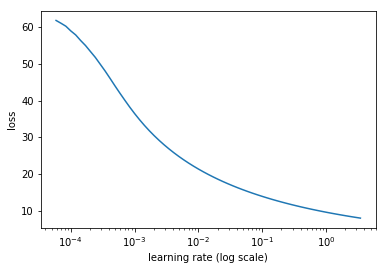

In [34]:
m.lr_find()
m.sched.plot()
# ??m.lr_find

In [35]:
lr = 1e-4

### Fit

`fit()` takes in a learning rate, number of epochs (the number of times the ENTIRE dataset is passed forward and backward through the neural network) and the metrics that we want to use as accuracy measure.

It returns 4 results: [`num_epoch` `training_loss`  `validation_loss`   `accuracy_score`]

What happens when `fit()` is called: 
1. Get embedding layer from embedding matrix for the categorical variable and concatenate them together.
2. Apply dropout on embedding layer.
3. Apply batch normalisation.
4. Go through each of the linear layer, apply ReLU (activation function) and dropout. 
5. Then the final layer will be 1 row x 1 column.
6. Apply sigmoid function on final linear layer to fit the output within y_range.

In [36]:
m.fit(lr, 10, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       6.69582  0.95777  2.20647]                      
[ 1.       1.52958  0.36583  0.9293 ]                      
[ 2.       0.51597  0.24827  0.63876]                       
[ 3.       0.26839  0.20576  0.51616]                       
[ 4.       0.1992   0.18586  0.44995]                       
[ 5.       0.17751  0.17566  0.41115]                       
[ 6.       0.16736  0.16992  0.38646]                       
[ 7.       0.16089  0.16639  0.3693 ]                       
[ 8.       0.16093  0.1641   0.35684]                       
[ 9.       0.15922  0.16262  0.34784]                       



In [37]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[ 0.       0.15416  0.15184  0.36016]                       
[ 1.       0.14203  0.15159  0.38298]                       
[ 2.       0.1383   0.15414  0.40039]                       
[ 3.       0.13856  0.15977  0.43355]                       
[ 4.       0.13268  0.15903  0.43408]                       
[ 5.       0.1306   0.16949  0.48252]                       



In [38]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.13032  0.16334  0.46177]                       
[ 1.       0.12716  0.17043  0.49091]                       
[ 2.       0.12733  0.16364  0.46256]                       
[ 3.       0.12629  0.17051  0.49461]                       



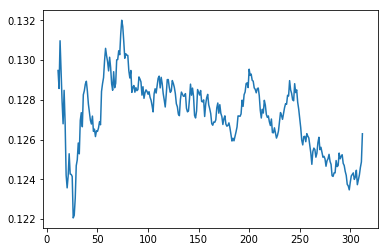

In [39]:
m.sched.plot_loss()

# Predict

### Run predictions on validation set

In [40]:
x,y=m.predict_with_targs()

In [41]:
exp_rmspe(x,y)

0.5025647959994142

/home/yenpingchew/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



Text(0.5,1,'Predictions')

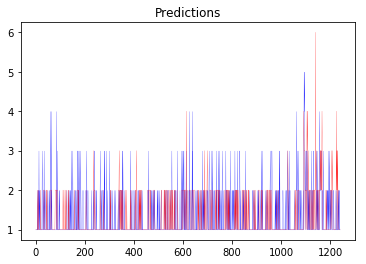

In [43]:
import matplotlib.pyplot as plt
import numpy as np

import plotly.plotly as py
import plotly.tools as tls
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

ax1.plot(np.exp(y)-0.01, linestyle='-', color='blue', linewidth=0.2)
ax1.set_title('Actual')

ax2.plot(np.round(np.exp(x)-0.01), linestyle='-', color='red', linewidth=0.2)
ax2.set_title('Predictions')

### Get predictions for test set

In [45]:
pred_test=m.predict(True)

In [46]:
pred_test = np.exp(pred_test)

### Compare predictions on test set against actual values


In [47]:
test_df['mrsa_count']=pred_test-1
test_df = test_df.reset_index()

backup = pd.DataFrame(test_df_backup_mrsa_rate, columns=['mrsa_count'])
backup.rename(columns={'mrsa_count': 'mrsa_count_ori'}, inplace=True)

compare_test_preds = pd.merge(test_df, backup, right_index=True, left_index=True)
compare_test_preds


,index,date,ccg_id,year,month,amoxicillin,ampicillin,benzylpenicillin-sodium,co-amoxiclav,flucloxacillin-magnesium,...,cefpodoxime,cefradine,ceftazidime,ceftriaxone-sodium,cefuroxime-sodium,ertapenem,imipenem-cilastatin,meropenem,mrsa_count,mrsa_count_ori
0,0,2017-06-01,0,2017,6,48804.0,0.0,0.0,5278.0,0.0,...,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.287112,0.0
1,1,2017-07-01,0,2017,7,55953.0,0.0,0.0,6381.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254266,0.0
2,2,2017-08-01,0,2017,8,46678.0,0.0,0.0,6012.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260688,0.0
3,3,2017-09-01,0,2017,9,50412.0,0.0,0.0,4870.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.225581,0.0
4,4,2017-10-01,0,2017,10,61677.0,0.0,0.0,5779.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269181,0.0
5,5,2017-11-01,0,2017,11,75454.0,0.0,0.0,6623.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.225595,0.0
6,6,2017-06-01,1,2017,6,126950.0,0.0,0.0,15256.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.447973,0.0
7,7,2017-07-01,1,2017,7,134160.0,0.0,1.0,14204.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.404868,0.0
8,8,2017-08-01,1,2017,8,125707.0,28.0,0.0,14391.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.495008,0.0
9,9,2017-09-01,1,2017,9,141204.0,0.0,0.0,13952.0,0.0,...,0.0,20.0,0.0,4.0,0.0,0.0,0.0,0.0,0.393369,0.0


/home/yenpingchew/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



Text(0.5,1,'Predictions')

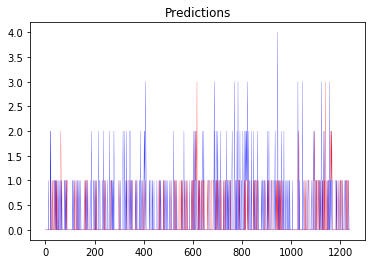

In [49]:
from sklearn.metrics import accuracy_score
actual = np.array(test_df_backup_mrsa_rate)
predictions = (pred_test)[:,0]
predictions

import matplotlib.pyplot as plt
import numpy as np

import plotly.plotly as py
import plotly.tools as tls
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

ax1.plot(actual, linestyle='-', color='blue', linewidth=0.2)
ax1.set_title('Actual')

ax2.plot(np.round(predictions-1), linestyle='-', color='red', linewidth=0.2)
ax2.set_title('Predictions')